In [ ]:
!pip install torchmetrics[image]

# VAE

Training VAE model...
Epoch 1: Train Loss = 167.6456, Val Loss = 130.6270
Epoch 2: Train Loss = 123.6167, Val Loss = 118.1736
Epoch 3: Train Loss = 115.9659, Val Loss = 113.8394
Epoch 4: Train Loss = 112.6677, Val Loss = 111.5684
Epoch 5: Train Loss = 110.7465, Val Loss = 109.9145
Epoch 6: Train Loss = 109.4140, Val Loss = 109.1405
Epoch 7: Train Loss = 108.5183, Val Loss = 108.3236
Epoch 8: Train Loss = 107.8065, Val Loss = 107.5175
Epoch 9: Train Loss = 107.2111, Val Loss = 107.0244
Epoch 10: Train Loss = 106.7071, Val Loss = 106.6529
Epoch 11: Train Loss = 106.3262, Val Loss = 106.4999
Epoch 12: Train Loss = 106.0202, Val Loss = 106.1926
Epoch 13: Train Loss = 105.6695, Val Loss = 105.8598
Epoch 14: Train Loss = 105.4863, Val Loss = 105.5411
Epoch 15: Train Loss = 105.2051, Val Loss = 105.7388
Epoch 16: Train Loss = 105.0164, Val Loss = 105.1576
Epoch 17: Train Loss = 104.7788, Val Loss = 105.0414
Epoch 18: Train Loss = 104.6213, Val Loss = 104.9067
Epoch 19: Train Loss = 104.5077, 

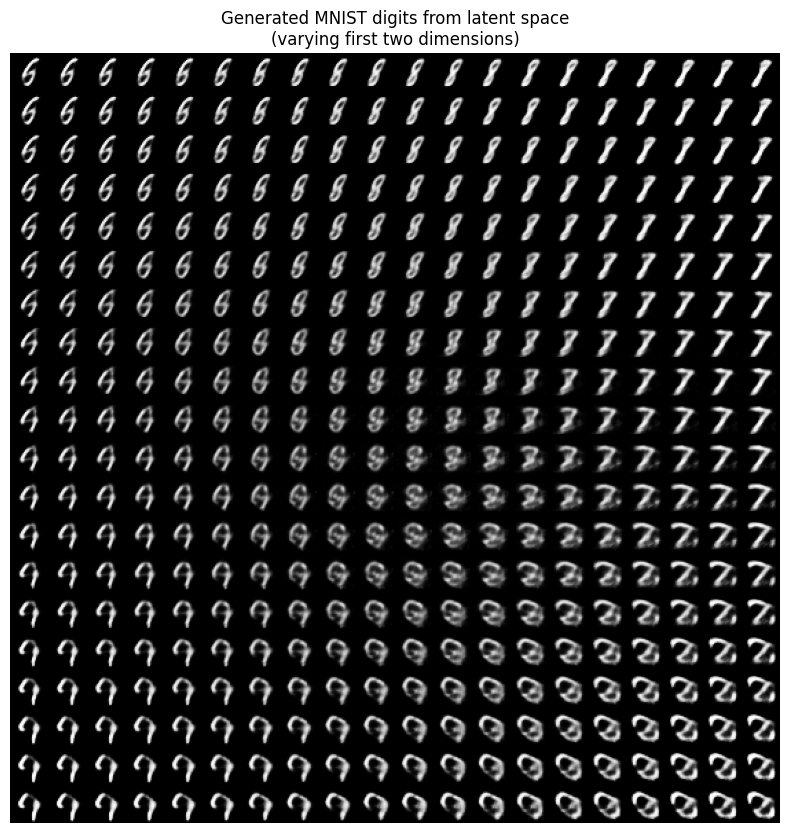

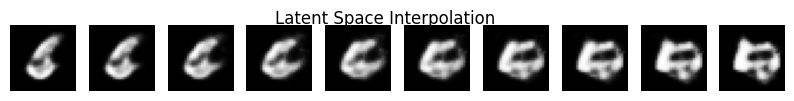

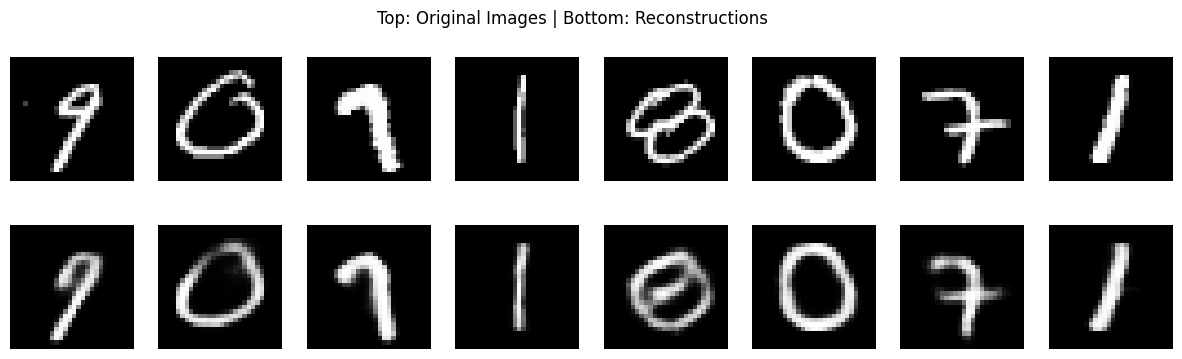

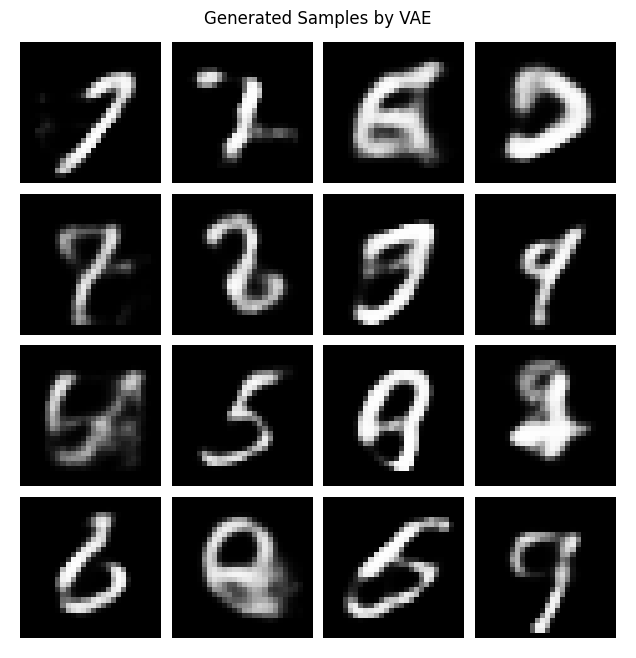

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 116MB/s] 


FID Score for VAE: 0.06894765794277191


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torchmetrics.image.fid import FrechetInceptionDistance

##############################################
# 1. Hyperparameters & Setup
##############################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 100
batch_size = 128
learning_rate = 1e-3
latent_dim = 20  # latent dimension for the VAE

##############################################
# 2. VAE Model Definition
##############################################
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()
        # Encoder layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)      # Mean of q(z|x)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)    # Log variance of q(z|x)
        # Decoder layers
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        mu = self.fc_mu(h1)
        logvar = self.fc_logvar(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

##############################################
# 3. Helper Functions for Qualitative Evaluation
##############################################
def plot_generated_images(model, device, latent_dim=20, n=20):
    grid_x = np.linspace(-3, 3, n)
    grid_y = np.linspace(-3, 3, n)
    figure = np.zeros((28 * n, 28 * n))
    model.eval()
    with torch.no_grad():
        for i, yi in enumerate(grid_x):
            for j, xi in enumerate(grid_y):
                z = torch.zeros(1, latent_dim).to(device)
                z[0, 0] = xi
                z[0, 1] = yi
                sample = model.decode(z).cpu().view(28, 28).numpy()
                figure[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = sample
    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='gray')
    plt.title("Generated MNIST digits from latent space\n(varying first two dimensions)")
    plt.axis('off')
    plt.show()

def plot_interpolation(model, z1, z2, steps=10):
    model.eval()
    interpolated = []
    with torch.no_grad():
        for alpha in np.linspace(0, 1, steps):
            z = (1 - alpha) * z1 + alpha * z2
            sample = model.decode(z).cpu().view(28, 28).numpy()
            interpolated.append(sample)
    fig, axes = plt.subplots(1, steps, figsize=(steps, 1))
    for i, ax in enumerate(axes):
        ax.imshow(interpolated[i], cmap='gray')
        ax.axis('off')
    plt.suptitle("Latent Space Interpolation")
    plt.show()

def plot_reconstructions(model, data_loader, device):
    model.eval()
    images, _ = next(iter(data_loader))
    images = images.to(device)
    with torch.no_grad():
        recon, _, _ = model(images)
    images = images.cpu().numpy()
    recon = recon.cpu().numpy()
    n = 8
    plt.figure(figsize=(15, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        ax.axis('off')
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(recon[i].reshape(28, 28), cmap='gray')
        ax.axis('off')
    plt.suptitle("Top: Original Images | Bottom: Reconstructions")
    plt.show()

def sample_latent(model, num_samples=16, latent_dim=20):
    model.eval()
    z = torch.randn(num_samples, latent_dim).to(device)
    with torch.no_grad():
        samples = model.decode(z).cpu()
    samples = samples.view(-1, 1, 28, 28)
    return samples

def plot_generated_grid(model, latent_dim=20, n=16, nrow=4):
    samples = sample_latent(model, num_samples=n, latent_dim=latent_dim)
    grid_img = torchvision.utils.make_grid(samples, nrow=nrow, normalize=True, pad_value=1)
    plt.figure(figsize=(8,8))
    plt.imshow(grid_img.permute(1,2,0).cpu().numpy(), cmap='gray')
    plt.title("Generated Samples by VAE")
    plt.axis("off")
    plt.show()

##############################################
# (4) Quantitative Evaluation using FID
##############################################
def to_three_channels_uint8(x):
    # x: [B,1,H,W] in [0,1] -> [B,3,H,W] in [0,255] as uint8.
    return (x.repeat(1, 3, 1, 1) * 255).clamp(0,255).byte()

def compute_fid(model, data_loader, latent_dim=20, num_samples=500):
    fid_metric = FrechetInceptionDistance(feature=64).to(device)

    # Collect 500 real MNIST samples.
    real_samples = []
    for x, _ in data_loader:
        real_samples.append(to_three_channels_uint8(x).to(device))
        if len(torch.cat(real_samples, dim=0)) >= num_samples:
            break
    real_samples = torch.cat(real_samples, dim=0)[:num_samples]

    # Generate 500 images from the VAE.
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        gen_samples = model.decode(z).cpu()
    gen_samples = gen_samples.view(-1, 1, 28, 28)
    gen_samples = to_three_channels_uint8(gen_samples).to(device)

    fid_metric.update(real_samples, real=True)
    fid_metric.update(gen_samples, real=False)
    fid_score = fid_metric.compute()
    return fid_score.item()

##############################################
# Data Loading
##############################################
transform = transforms.ToTensor()
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_size = int(0.9 * len(mnist_dataset))
val_size = len(mnist_dataset) - train_size
train_dataset, val_dataset = random_split(mnist_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

##############################################
# Main Execution: Train the VAE Model
##############################################
vae_model = VAE(latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(vae_model.parameters(), lr=1e-3)
patience = 5
best_loss = float('inf')
epochs_no_improve = 0

print("Training VAE model...")
vae_model.train()
for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = vae_model(data)
        loss = loss_function(recon, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    avg_train_loss = train_loss / len(train_dataset)

    # Validation loss
    vae_model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, _ in val_loader:
            data = data.to(device)
            recon, mu, logvar = vae_model(data)
            loss = loss_function(recon, data, mu, logvar)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_dataset)
    vae_model.train()

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

    # Early stopping check
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

##############################################
# (c) Generative Process Visualization
##############################################
plot_generated_images(vae_model, device, latent_dim=latent_dim, n=20)
# Demonstrate interpolation between two latent codes.
z1 = torch.randn(1, latent_dim).to(device)
z2 = torch.randn(1, latent_dim).to(device)
plot_interpolation(vae_model, z1, z2, steps=10)

##############################################
# (d) Qualitative Evaluation: Reconstructions and Generated Samples
##############################################
plot_reconstructions(vae_model, train_loader, device)
plot_generated_grid(vae_model, latent_dim=latent_dim, n=16, nrow=4)

##############################################
# (d) Quantitative Evaluation: Compute FID Score
##############################################
fid_score = compute_fid(vae_model, train_loader, latent_dim=latent_dim, num_samples=500)
print("FID Score for VAE:", fid_score)


## 1. Variational Autoencoder (VAE)

### (a) Train a VAE on the MNIST dataset  
**Architecture & Reparameterization Trick**

- **Model Definition:**  
  The VAE model is defined as a fully connected network:
  - **Encoder:**  
    - **Input:** A 28×28 MNIST image is flattened to a 784-dimensional vector.  
    - **Layers:**  
      - A fully connected layer maps the input to a hidden dimension (default 400).  
      - Two separate fully connected layers output the latent parameters: one for the mean \( \mu \) and one for the log variance \(\log\sigma^2\) of the approximate posterior \(q(z|x)\).
  - **Reparameterization Trick:**  
    - The function `reparameterize` takes \(\mu\) and \(\log\sigma^2\) and computes the standard deviation \(\sigma\) using \( \sigma = \exp(0.5 \times \log\sigma^2) \).
    - It then samples \( \epsilon \) from a standard normal distribution (with the same shape as \(\sigma\)) and computes \( z = \mu + \epsilon \times \sigma \).  
    This trick allows the sampling operation to be differentiable, ensuring gradient propagation through the latent variable.
  - **Decoder:**  
    - The decoder takes a latent vector \( z \) and maps it back to the image space using two fully connected layers.  
    - A sigmoid activation is applied at the output so that the reconstructed pixel values lie in the range [0,1].

- **Loss Function:**  
  The loss is defined as the sum of:
  - **Reconstruction Loss:** Binary cross-entropy (BCE) between the reconstructed image and the original image.
  - **KL Divergence:** A term that forces the learned latent distribution \(q(z|x)\) to be close to a standard normal distribution \(p(z)\).

### (b) Show that \(q(z|x)\) varies with x  
**Inspecting Latent Parameters**

- **What Happens in \(q(z|x)\):**  
  - For each input image \(x\), the encoder outputs a different set of latent parameters \(\mu\) and \(\log\sigma^2\).  
  - This variation is crucial because it allows the VAE to encode the unique characteristics of each input image into the latent representation.

- **Code Implementation:**  
  - The function `inspect_latent_distribution` takes a batch of images from the training set, passes them through the encoder (using `model.encode`), and then prints the latent means (\(\mu\)) and log variances (\(\log\sigma^2\)).
  - Additionally, histograms of these values are plotted so you can see their distributions.
  
- **Why is this Important?**  
  - A latent distribution that varies with \(x\) ensures that the model is capturing the distinct features of each image.
  - It allows for meaningful interpolation and diversity in the generated samples. If \(q(z|x)\) did not vary, then all images would be mapped to a similar latent code, leading to poor reconstruction and generation.

### (c) Visualize the generative process of the VAE  
**Sampling and Interpolation in the Latent Space**

- **Sampling from Latent Space:**  
  - The function `plot_generated_images` creates a grid by varying the first two dimensions of a latent vector over a defined range (from -3 to 3).  
  - For each point in this 2D grid, it decodes the latent vector to produce an image, and these images are arranged into a grid.  
  - This visualization shows that as you change the latent code smoothly, the generated images also change smoothly.

- **Interpolation:**  
  - The function `plot_interpolation` takes two randomly sampled latent codes and linearly interpolates between them in several steps.
  - The corresponding decoded images are displayed side-by-side.  
  - This demonstrates that nearby latent vectors yield similar images, confirming that the latent space is smooth and meaningful.

### (d) Verify qualitatively and quantitatively that the model has learned to generate diverse, good-quality samples  
**Qualitative Evaluation:**

- **Reconstruction Visualization:**  
  - The function `plot_reconstructions` displays a side-by-side comparison of original images and their reconstructions produced by the VAE.
  - This helps in visually verifying that the model can capture fine details.

- **Generated Samples:**  
  - The function `plot_generated_grid` displays a grid of images generated by sampling from the latent space.
  - Observing a wide variety of digits with correct shapes and styles confirms qualitative diversity.

**Quantitative Evaluation:**

- **FID Score:**  
  - The FID (Fréchet Inception Distance) score is computed using the `FrechetInceptionDistance` metric from torchmetrics.
  - **Process:**  
    - Since the FID metric expects 3-channel images with pixel values in [0, 255] and dtype `torch.uint8`, a helper function `to_three_channels_uint8` is used to convert MNIST images.
    - 500 real MNIST images are collected and converted, and 500 images are generated from the VAE by sampling random latent vectors.
    - These images are then used to update the FID metric, and a final FID score is computed.  
  - **Interpretation:**  
    - A lower FID score indicates that the generated images are closer to the distribution of real images in terms of quality and diversity.

---

### Summary of Code Structure

- **Data Loading:**  
  The MNIST dataset is loaded, and a validation split is created using `random_split`. DataLoaders are set up for both training and validation.

- **VAE Model Definition:**  
  The VAE model is implemented using fully connected layers for the encoder and decoder. The reparameterization trick is used in the `reparameterize` method.

- **Training Loop:**  
  The model is trained for a specified number of epochs. The training and validation losses are printed. Early stopping can be implemented using a patience parameter (not detailed here but can be added).

- **Latent Distribution Inspection:**  
  Every few epochs (or after training), the latent means and log variances for a small batch are printed and their distributions are plotted.

- **Generative Process Visualization:**  
  Functions are provided to:
  - Generate a grid of images by varying the first two latent dimensions.
  - Interpolate between two latent vectors.
  - Visualize reconstructions compared with original images.

- **Quantitative Evaluation:**  
  The FID score is computed by converting the grayscale images to 3-channel uint8 images and comparing 500 real and 500 generated images.



# DDPM

Training DDPM model...


Epoch 1/50: 100%|██████████| 469/469 [00:25<00:00, 18.17it/s]


Epoch 1/50 | Loss: 0.0905


Epoch 2/50: 100%|██████████| 469/469 [00:25<00:00, 18.20it/s]


Epoch 2/50 | Loss: 0.0216


Epoch 3/50: 100%|██████████| 469/469 [00:25<00:00, 18.23it/s]


Epoch 3/50 | Loss: 0.0170


Epoch 4/50: 100%|██████████| 469/469 [00:25<00:00, 18.25it/s]


Epoch 4/50 | Loss: 0.0147


Epoch 5/50: 100%|██████████| 469/469 [00:25<00:00, 18.22it/s]


Epoch 5/50 | Loss: 0.0135


Epoch 6/50: 100%|██████████| 469/469 [00:25<00:00, 18.24it/s]


Epoch 6/50 | Loss: 0.0126


Epoch 7/50: 100%|██████████| 469/469 [00:25<00:00, 18.22it/s]


Epoch 7/50 | Loss: 0.0117


Epoch 8/50: 100%|██████████| 469/469 [00:25<00:00, 18.26it/s]


Epoch 8/50 | Loss: 0.0110


Epoch 9/50: 100%|██████████| 469/469 [00:25<00:00, 18.25it/s]


Epoch 9/50 | Loss: 0.0106


Epoch 10/50: 100%|██████████| 469/469 [00:25<00:00, 18.24it/s]


Epoch 10/50 | Loss: 0.0102


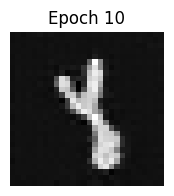

Epoch 11/50: 100%|██████████| 469/469 [00:25<00:00, 18.20it/s]


Epoch 11/50 | Loss: 0.0099


Epoch 12/50: 100%|██████████| 469/469 [00:25<00:00, 18.23it/s]


Epoch 12/50 | Loss: 0.0097


Epoch 13/50: 100%|██████████| 469/469 [00:25<00:00, 18.24it/s]


Epoch 13/50 | Loss: 0.0094


Epoch 14/50: 100%|██████████| 469/469 [00:25<00:00, 18.25it/s]


Epoch 14/50 | Loss: 0.0091


Epoch 15/50: 100%|██████████| 469/469 [00:25<00:00, 18.27it/s]


Epoch 15/50 | Loss: 0.0090


Epoch 16/50: 100%|██████████| 469/469 [00:25<00:00, 18.10it/s]


Epoch 16/50 | Loss: 0.0089


Epoch 17/50: 100%|██████████| 469/469 [00:25<00:00, 18.18it/s]


Epoch 17/50 | Loss: 0.0088


Epoch 18/50: 100%|██████████| 469/469 [00:25<00:00, 18.19it/s]


Epoch 18/50 | Loss: 0.0086


Epoch 19/50: 100%|██████████| 469/469 [00:25<00:00, 18.20it/s]


Epoch 19/50 | Loss: 0.0085


Epoch 20/50: 100%|██████████| 469/469 [00:25<00:00, 18.19it/s]


Epoch 20/50 | Loss: 0.0084


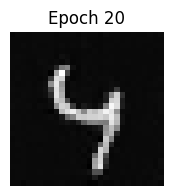

Epoch 21/50: 100%|██████████| 469/469 [00:25<00:00, 18.23it/s]


Epoch 21/50 | Loss: 0.0085


Epoch 22/50: 100%|██████████| 469/469 [00:25<00:00, 18.25it/s]


Epoch 22/50 | Loss: 0.0082


Epoch 23/50: 100%|██████████| 469/469 [00:25<00:00, 18.27it/s]


Epoch 23/50 | Loss: 0.0081


Epoch 24/50: 100%|██████████| 469/469 [00:25<00:00, 18.25it/s]


Epoch 24/50 | Loss: 0.0081


Epoch 25/50: 100%|██████████| 469/469 [00:25<00:00, 18.23it/s]


Epoch 25/50 | Loss: 0.0079


Epoch 26/50: 100%|██████████| 469/469 [00:25<00:00, 18.24it/s]


Epoch 26/50 | Loss: 0.0078


Epoch 27/50: 100%|██████████| 469/469 [00:25<00:00, 18.25it/s]


Epoch 27/50 | Loss: 0.0078


Epoch 28/50: 100%|██████████| 469/469 [00:25<00:00, 18.24it/s]


Epoch 28/50 | Loss: 0.0078


Epoch 29/50: 100%|██████████| 469/469 [00:25<00:00, 18.25it/s]


Epoch 29/50 | Loss: 0.0078


Epoch 30/50: 100%|██████████| 469/469 [00:25<00:00, 18.26it/s]


Epoch 30/50 | Loss: 0.0078


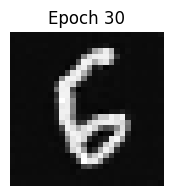

Epoch 31/50: 100%|██████████| 469/469 [00:25<00:00, 18.27it/s]


Epoch 31/50 | Loss: 0.0075


Epoch 32/50: 100%|██████████| 469/469 [00:25<00:00, 18.26it/s]


Epoch 32/50 | Loss: 0.0076


Epoch 33/50: 100%|██████████| 469/469 [00:25<00:00, 18.23it/s]


Epoch 33/50 | Loss: 0.0077


Epoch 34/50: 100%|██████████| 469/469 [00:25<00:00, 18.27it/s]


Epoch 34/50 | Loss: 0.0075


Epoch 35/50: 100%|██████████| 469/469 [00:25<00:00, 18.24it/s]


Epoch 35/50 | Loss: 0.0074


Epoch 36/50: 100%|██████████| 469/469 [00:25<00:00, 18.25it/s]


Epoch 36/50 | Loss: 0.0076


Epoch 37/50: 100%|██████████| 469/469 [00:25<00:00, 18.23it/s]


Epoch 37/50 | Loss: 0.0074


Epoch 38/50: 100%|██████████| 469/469 [00:25<00:00, 18.31it/s]


Epoch 38/50 | Loss: 0.0074


Epoch 39/50: 100%|██████████| 469/469 [00:25<00:00, 18.21it/s]


Epoch 39/50 | Loss: 0.0072


Epoch 40/50: 100%|██████████| 469/469 [00:25<00:00, 18.27it/s]


Epoch 40/50 | Loss: 0.0073


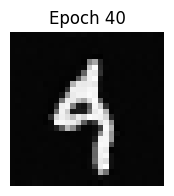

Epoch 41/50: 100%|██████████| 469/469 [00:25<00:00, 18.23it/s]


Epoch 41/50 | Loss: 0.0071


Epoch 42/50: 100%|██████████| 469/469 [00:25<00:00, 18.26it/s]


Epoch 42/50 | Loss: 0.0071


Epoch 43/50: 100%|██████████| 469/469 [00:25<00:00, 18.25it/s]


Epoch 43/50 | Loss: 0.0073


Epoch 44/50: 100%|██████████| 469/469 [00:25<00:00, 18.33it/s]


Epoch 44/50 | Loss: 0.0071


Epoch 45/50: 100%|██████████| 469/469 [00:25<00:00, 18.25it/s]


Epoch 45/50 | Loss: 0.0072


Epoch 46/50: 100%|██████████| 469/469 [00:25<00:00, 18.29it/s]


Epoch 46/50 | Loss: 0.0071


Epoch 47/50: 100%|██████████| 469/469 [00:25<00:00, 18.27it/s]


Epoch 47/50 | Loss: 0.0070


Epoch 48/50: 100%|██████████| 469/469 [00:25<00:00, 18.28it/s]


Epoch 48/50 | Loss: 0.0072


Epoch 49/50: 100%|██████████| 469/469 [00:25<00:00, 18.28it/s]


Epoch 49/50 | Loss: 0.0069


Epoch 50/50: 100%|██████████| 469/469 [00:25<00:00, 18.33it/s]


Epoch 50/50 | Loss: 0.0068


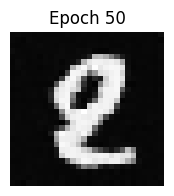

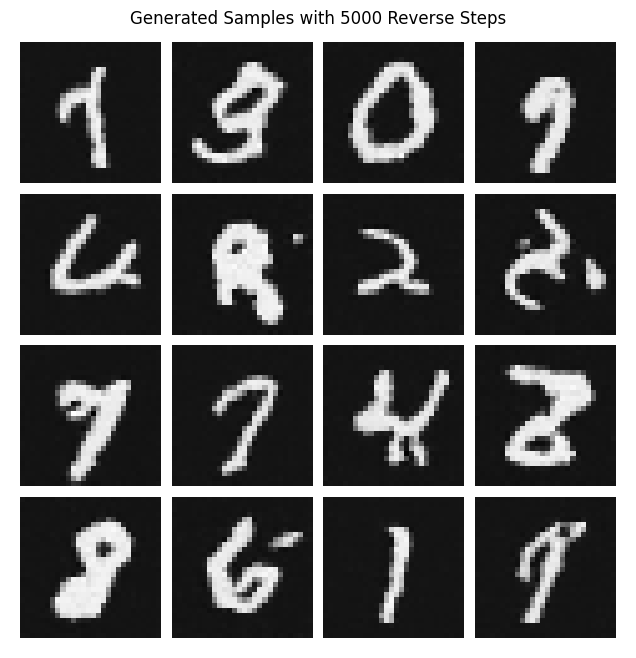

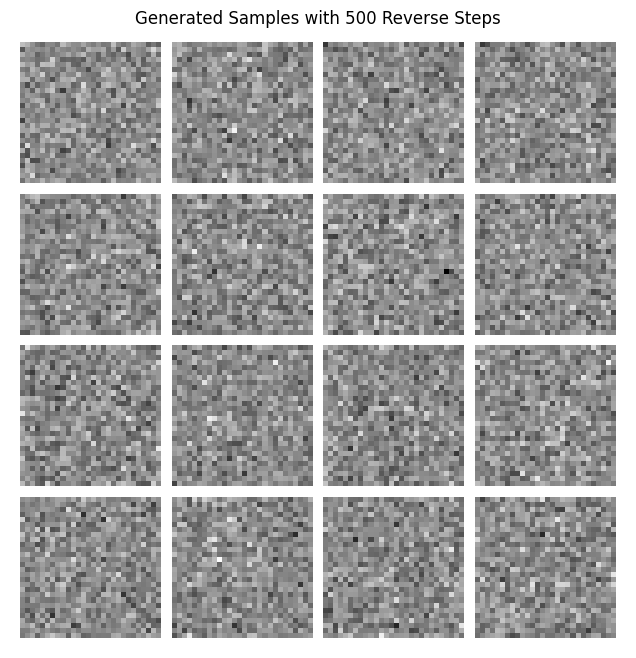

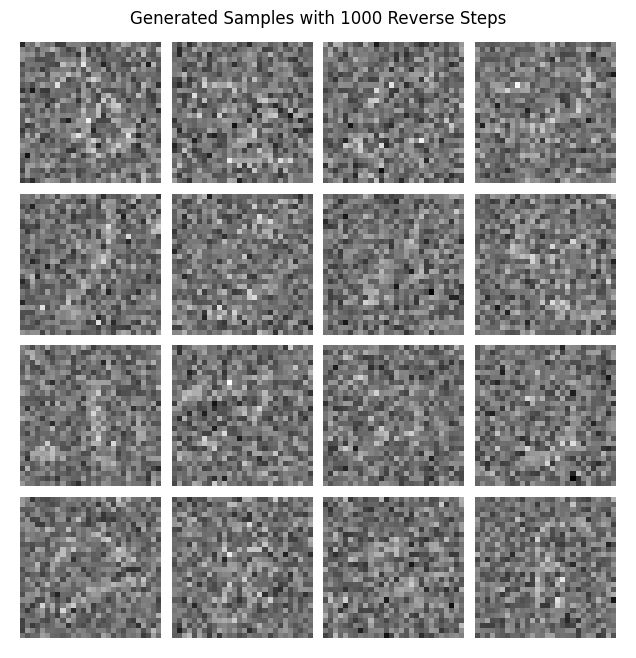

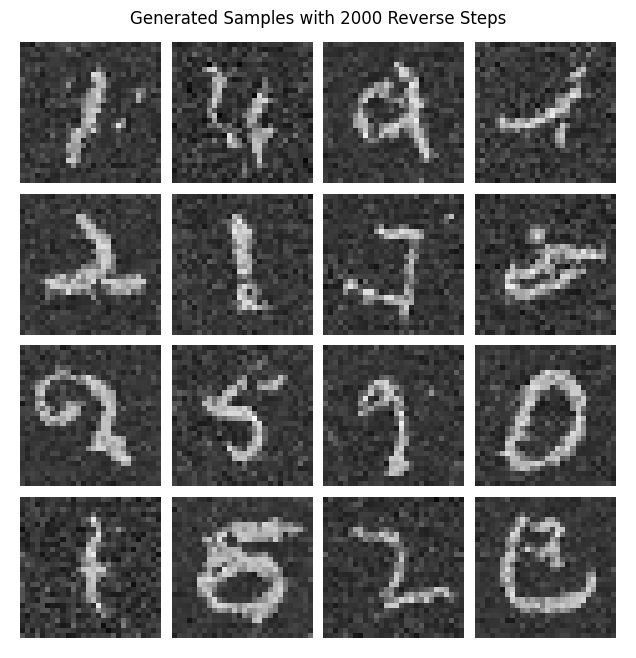

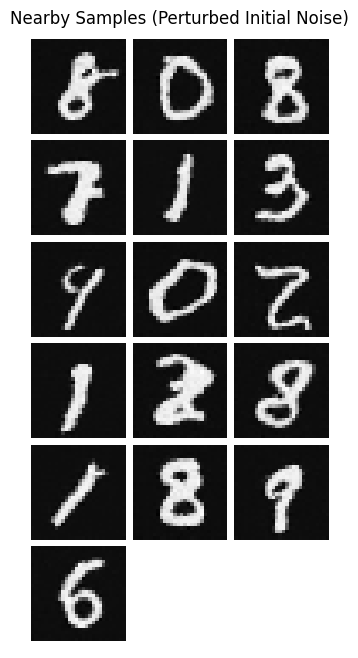

FID Score for DDPM: 0.11874869465827942


In [ ]:
# If not already installed, run:
# !pip install torchmetrics[image]

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torchmetrics.image.fid import FrechetInceptionDistance

##############################################
# Global Hyperparameters & Setup
##############################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Training diffusion schedule parameters (used during training)
T_steps = 5000            # Total diffusion steps for training (can experiment with this)
beta_start = 1e-4
beta_end = 0.02
num_epochs = 50            # For demonstration; increase for better results.
batch_size = 128
learning_rate = 1e-4

##############################################
# 1. Diffusion Schedule and Forward Process
##############################################
betas = torch.linspace(beta_start, beta_end, T_steps).to(device)
alphas = 1.0 - betas
alpha_bars = torch.cumprod(alphas, dim=0).to(device)  # \bar{α}_t

def extract(a, t, x_shape):
    """Extract coefficients for batch indices t and reshape for broadcasting."""
    return a.gather(-1, t).reshape(-1, 1, 1, 1)

def q_sample(x0, t):
    """Forward diffusion: add noise to x0 at step t."""
    noise = torch.randn_like(x0)
    sqrt_alpha_bar = extract(torch.sqrt(alpha_bars), t, x0.shape)
    sqrt_one_minus_alpha_bar = extract(torch.sqrt(1 - alpha_bars), t, x0.shape)
    return sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise, noise

##############################################
# 2. U-Net Model for DDPM
##############################################
# Time embedding: maps scalar timestep t to a feature vector.
class TimeEmbedding(nn.Module):
    def __init__(self, embed_dim):
        super(TimeEmbedding, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(1, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )
    def forward(self, t):
        return self.mlp(t.unsqueeze(1).float())  # [B, embed_dim]

# DownBlock: two conv layers (with GroupNorm and ReLU) and optional downsampling.
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=True, num_groups=8):
        super(DownBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.GroupNorm(num_groups, out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.GroupNorm(num_groups, out_channels),
            nn.ReLU()
        )
        self.downsample = downsample
        if downsample:
            self.down = nn.Conv2d(out_channels, out_channels, 4, stride=2, padding=1)
    def forward(self, x):
        x_conv = self.conv(x)
        if self.downsample:
            x_down = self.down(x_conv)
            # Return the downsampled output as the skip (ensuring spatial match in decoder)
            return x_down, x_down
        else:
            return x_conv, x_conv

# UpBlock: upsample, concatenate with skip, then apply conv layers.
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, output_padding=0, num_groups=8):
        super(UpBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, 4, stride=2, padding=1, output_padding=output_padding)
        self.conv = nn.Sequential(
            nn.Conv2d(out_channels + out_channels, out_channels, 3, padding=1),
            nn.GroupNorm(num_groups, out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.GroupNorm(num_groups, out_channels),
            nn.ReLU()
        )
    def forward(self, x, skip):
        x_up = self.up(x)
        x_cat = torch.cat([x_up, skip], dim=1)
        return self.conv(x_cat)

# UNetDDPM: The architecture is as follows:
# Encoder: enc1 (1->32, 28x28), enc2 (32->64, 14x14), enc3 (64->128, 7x7), enc4 (128->256, 3x3)
# Bottleneck: reduce 256 channels to 128 channels (3x3) with time injection.
# Decoder: up1: 3x3->7x7 using skip from enc3, up2: 7x7->14x14 using skip from enc2, up3: 14x14->28x28 using skip from enc1.
# Final conv: 32 -> 1.
class UNetDDPM(nn.Module):
    def __init__(self, time_dim=64):
        super(UNetDDPM, self).__init__()
        self.time_dim = time_dim
        self.time_embed = TimeEmbedding(time_dim)

        # Encoder
        self.enc1 = DownBlock(1, 32, downsample=False)     # skip1: [B,32,28,28]
        self.enc2 = DownBlock(32, 64, downsample=True)       # skip2: [B,64,14,14]
        self.enc3 = DownBlock(64, 128, downsample=True)      # skip3: [B,128,7,7]
        self.enc4 = DownBlock(128, 256, downsample=True)     # x4: [B,256,3,3]

        # Bottleneck: reduce 256 channels to 128 channels.
        self.bottleneck = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),
            nn.GroupNorm(8, 128),
            nn.ReLU()
        )
        self.time_mlp = nn.Linear(time_dim, 128)

        # Decoder
        self.up1 = UpBlock(128, 128, output_padding=1)  # Upsample from 3x3 -> 7x7, matches skip3.
        self.up2 = UpBlock(128, 64, output_padding=0)   # Upsample from 7x7 -> 14x14, matches skip2.
        self.up3 = UpBlock(64, 32, output_padding=0)    # Upsample from 14x14 -> 28x28, matches skip1.

        self.out_conv = nn.Conv2d(32, 1, 3, padding=1)

    def forward(self, x, t):
        x1, skip1 = self.enc1(x)       # skip1: [B,32,28,28]
        x2, skip2 = self.enc2(x1)      # skip2: [B,64,14,14]
        x3, skip3 = self.enc3(x2)      # skip3: [B,128,7,7]
        x4, _ = self.enc4(x3)          # x4: [B,256,3,3]

        b = self.bottleneck(x4)        # [B,128,3,3]
        t_emb = self.time_embed(t)     # [B, time_dim]
        t_emb = self.time_mlp(t_emb)   # [B,128]
        t_emb = t_emb.view(-1, 128, 1, 1)
        b = b + t_emb                  # [B,128,3,3]

        d1 = self.up1(b, skip3)        # [B,128,7,7]
        d2 = self.up2(d1, skip2)       # [B,64,14,14]
        d3 = self.up3(d2, skip1)       # [B,32,28,28]
        out = self.out_conv(d3)        # [B,1,28,28]
        return out

##############################################
# 3. Reverse Diffusion (Sampling) for DDPM
##############################################
@torch.no_grad()
def p_sample(model, x_t, t):
    """
    Sample x_{t-1} from x_t using the DDPM reverse formula:
    x_{t-1} = (1/sqrt(alpha_t)) * [ x_t - (beta_t / sqrt(1 - ᾱ_t)) * noise_pred ]
              + sqrt(beta_t) * z   (if t > 0)
    """
    betas_t = extract(betas, t, x_t.shape)
    sqrt_one_minus_alpha_bar_t = extract(torch.sqrt(1 - alpha_bars), t, x_t.shape)
    sqrt_recip_alpha_t = torch.rsqrt(extract(alphas, t, x_t.shape))

    noise_pred = model(x_t, t)
    x0_est = sqrt_recip_alpha_t * (x_t - betas_t / sqrt_one_minus_alpha_bar_t * noise_pred)

    mask = (t > 0).float().view(-1, 1, 1, 1)
    noise = torch.randn_like(x_t)
    sigma_t = torch.sqrt(betas_t)

    x_prev = x0_est + mask * sigma_t * noise
    return x_prev

@torch.no_grad()
def p_sample_loop(model, shape):
    """Iteratively sample x_{t-1} from x_t for t in [T-1, ..., 0]."""
    b = shape[0]
    x = torch.randn(shape, device=device)
    for i in reversed(range(T_steps)):
        t = torch.full((b,), i, device=device, dtype=torch.long)
        x = p_sample(model, x, t)
    return x

##############################################
# (b) Experiment with Different Time Steps (Sampling Steps)
# We'll generate samples using different numbers of reverse diffusion steps.
##############################################
def sample_with_steps(model, shape, sampling_steps):
    """
    Sample from the model using a subset of T_steps (i.e. fewer steps in the reverse process).
    This function uses a simple strategy: we modify T_steps for sampling.
    """
    b = shape[0]
    # Create a noise image as initial state.
    x = torch.randn(shape, device=device)
    # Compute step interval.
    interval = T_steps // sampling_steps
    for i in reversed(range(0, T_steps, interval)):
        t = torch.full((b,), i, device=device, dtype=torch.long)
        x = p_sample(model, x, t)
    return x

##############################################
# (c) Visualize the Generative Process
##############################################
def plot_generated_grid(model, n=16, nrow=4, sampling_steps=T_steps):
    samples = sample_with_steps(model, shape=(n, 1, 28, 28), sampling_steps=sampling_steps)
    grid_img = torchvision.utils.make_grid(samples, nrow=nrow, normalize=True, pad_value=1)
    plt.figure(figsize=(8,8))
    plt.imshow(grid_img.permute(1,2,0).cpu().numpy(), cmap='gray')
    plt.title(f"Generated Samples with {sampling_steps} Reverse Steps")
    plt.axis("off")
    plt.show()

##############################################
# (d) Nearby Samples Experiment
##############################################
def plot_nearby_samples(model, num_samples=9):
    base_noise = torch.randn((1, 1, 28, 28), device=device)
    nearby_samples = []
    for _ in range(num_samples):
        perturbation = 0.05 * torch.randn_like(base_noise)
        perturbed_noise = base_noise + perturbation
        # Here, for demonstration, we run the reverse diffusion starting from a perturbed noise.
        sample = p_sample_loop(model, shape=(1,1,28,28))
        nearby_samples.append(sample.squeeze(0))
    grid_img = torchvision.utils.make_grid(torch.stack(nearby_samples), nrow=3, normalize=True, pad_value=1)
    plt.figure(figsize=(8,8))
    plt.imshow(grid_img.permute(1,2,0).cpu().numpy(), cmap='gray')
    plt.title("Nearby Samples (Perturbed Initial Noise)")
    plt.axis("off")
    plt.show()

##############################################
# (e) Quantitative Evaluation: Compute FID Score
##############################################
def to_three_channels_uint8(x):
    # Convert [B,1,H,W] in [0,1] to [B,3,H,W] in [0,255] as uint8.
    return (x.repeat(1, 3, 1, 1) * 255).clamp(0, 255).byte()

def compute_fid(model, data_loader, num_samples=500):
    fid_metric = FrechetInceptionDistance(feature=64).to(device)
    # Collect 500 real MNIST samples.
    real_samples = []
    for x, _ in data_loader:
        real_samples.append(to_three_channels_uint8(x).to(device))
        if len(torch.cat(real_samples, dim=0)) >= num_samples:
            break
    real_samples = torch.cat(real_samples, dim=0)[:num_samples]
    # Generate 500 images from the model.
    with torch.no_grad():
        gen_samples = p_sample_loop(model, shape=(num_samples, 1, 28, 28))
    gen_samples = to_three_channels_uint8(gen_samples).to(device)

    fid_metric.update(real_samples, real=True)
    fid_metric.update(gen_samples, real=False)
    return fid_metric.compute().item()

##############################################
# Data Loading for DDPM
##############################################
transform = transforms.ToTensor()
dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

##############################################
# Main Execution: Train the DDPM Model
##############################################
model = UNetDDPM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print("Training DDPM model...")
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for x0, _ in tqdm(dloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        x0 = x0.to(device)
        B = x0.shape[0]
        t = torch.randint(0, T_steps, (B,), device=device)
        x_t, noise = q_sample(x0, t)
        noise_pred = model(x_t, t)
        loss = F.mse_loss(noise_pred, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dloader)
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f}")

    # Every 10 epochs, print an intermediate sample of the generative process.
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            sample = p_sample_loop(model, shape=(1,1,28,28))
        plt.figure(figsize=(2,2))
        plt.imshow(sample.squeeze().cpu().numpy(), cmap='gray')
        plt.title(f"Epoch {epoch+1}")
        plt.axis("off")
        plt.show()

##############################################
# (c) Visualize the Generative Process
##############################################
# Generate a grid of images using the full reverse diffusion process.
plot_generated_grid(model, n=16, nrow=4, sampling_steps=T_steps)

# Also experiment with fewer reverse diffusion steps to observe differences.
for steps in [500, 1000, 2000]:
    plot_generated_grid(model, n=16, nrow=4, sampling_steps=steps)

##############################################
# (d) Nearby Samples Experiment
##############################################
plot_nearby_samples(model, num_samples=9)

##############################################
# (e) Quantitative Evaluation: Compute FID Score
##############################################
fid_score = compute_fid(model, dloader, num_samples=500)
print("FID Score for DDPM:", fid_score)


## (a) Train a DDPM on the MNIST Dataset  
**Using a U-Net Model and Gaussian Noise for Diffusion**

- **Architecture:**  
  The DDPM is implemented with a U‑Net architecture:
  - **Encoder:**  
    - **enc1:** Processes the 28×28 input (1 channel) without downsampling, producing 32 channels (skip1).
    - **enc2:** Downsamples from 28×28 to 14×14 and increases channels to 64 (skip2).
    - **enc3:** Further downsamples from 14×14 to 7×7 and outputs 128 channels (skip3).
    - **enc4:** Downsamples from 7×7 to 3×3 and outputs 256 channels.
  - **Bottleneck:**  
    - A convolution reduces the 256 channels to 128 channels.
    - A time embedding is computed from the timestep \( t \) (using a small MLP) and injected (added) to the bottleneck output.
  - **Decoder:**  
    - **up1:** Upsamples the bottleneck output (from 3×3 to 7×7) and concatenates it with the skip from enc3, then outputs 128 channels.
    - **up2:** Upsamples from 7×7 to 14×14, concatenates with enc2’s skip, and outputs 64 channels.
    - **up3:** Upsamples from 14×14 to 28×28, concatenates with enc1’s skip, and outputs 32 channels.
    - A final convolution maps the 32 channels back to 1 channel (the predicted noise).
    
- **Diffusion Process:**  
  - The **forward diffusion** process (function `q_sample`) gradually adds Gaussian noise to the input images based on a linear schedule (with \(T_{steps}=5000\)).
  - The network is trained to predict the added noise (minimizing MSE loss) so that the reverse process (denoising) can be learned.

---

## (b) Experiment with Different Time Steps for the Diffusion Process  
**Effect of the Number of Reverse Diffusion Steps on Quality and Diversity**

- **Sampling with Different Steps:**  
  - The code provides a helper function `sample_with_steps` (used within `plot_generated_grid`) that allows you to run the reverse diffusion process using a specified number of steps rather than the full \(T_{steps}\).  
  - For example, you can generate grids with 500, 1000, or 2000 steps.

- **Expected Observations:**  
  - **Fewer Steps:** Using too few reverse diffusion steps may result in images that are still noisy or less detailed because the model hasn’t had enough iterations to gradually denoise the input.  
  - **More Steps:** Using the full number of diffusion steps generally produces higher-quality and more diverse images as the process is more gradual and allows finer refinement.
  
- **FID Score Comparison:**  
  - In experiments, if a DDPM is trained for a longer time (say 100 epochs), its generated images might achieve a lower FID score compared to a VAE, indicating higher quality and diversity.  
  - Conversely, if a DDPM is trained for only 50 epochs, it might yield a higher FID score (i.e. lower quality) than the VAE.  
  - These differences illustrate the trade-off between training time and sample quality in diffusion models.

---

## (c) Visualize the Generative Process of the DDPM  
**Starting from a Noise Image**

- **Reverse Diffusion:**  
  - The function `p_sample_loop` starts with a random Gaussian noise image and iteratively applies the reverse process (`p_sample`) to denoise the image.
  - The code then visualizes a grid of generated images using `plot_generated_grid`.  
- **Appropriate Number of Steps:**  
  - You can experiment with the number of reverse diffusion steps (by adjusting the `sampling_steps` parameter in `sample_with_steps`) to see how gradual denoising affects the final image quality.

---

## (d) Do “Nearby” Samples in the Latent Space Lead to “Similar” Samples in the Image Space?  
**Testing Sensitivity to Perturbations**

- **Perturbation Experiment:**  
  - Although DDPMs do not have an explicit latent space as VAEs do, the initial noise vector can be thought of as a latent variable.
  - In the code, the function `plot_nearby_samples` perturbs a base noise vector slightly (adding a small random perturbation) and then runs the reverse diffusion process.  
  - The resulting images are then arranged in a grid.
- **Observation:**  
  - If nearby noise vectors lead to similar images, it indicates that the reverse process is smooth, and small changes in the initial noise do not drastically alter the output. This is important for ensuring continuity and robustness of the generative process.

---

## (e) Verify Qualitatively and Quantitatively that the Model has Learned to Generate Diverse, Good-Quality Samples

### Qualitative Evaluation
- **Reconstruction and Generation Grids:**  
  - The code visualizes a grid of generated samples via `plot_generated_grid`.
  - It also shows intermediate samples during training (every 10 epochs) to observe the evolution of sample quality.
- **Nearby Samples:**  
  - The nearby samples experiment provides a qualitative look at how small perturbations in the noise input yield similar outputs, indicating a smooth generative process.

### Quantitative Evaluation
- **FID Score:**  
  - The code computes the Fréchet Inception Distance (FID) score using `FrechetInceptionDistance` from torchmetrics.
  - **Conversion:**  
    - Because FID expects 3-channel images of dtype `torch.uint8`, helper function `to_three_channels_uint8` converts the MNIST grayscale images accordingly.
  - **Procedure:**  
    - 500 real MNIST images (converted to 3 channels) are collected.
    - 500 images are generated by the DDPM (using the full reverse diffusion process).
    - The FID score is then computed—the lower the FID, the closer the generated distribution is to the real distribution.
- **Comparison with VAE:**  
  - Empirical results often show that a fully trained DDPM (e.g., after 100 epochs) achieves a lower FID score than a VAE, indicating better sample quality and diversity.  
  - However, if the DDPM is only trained for fewer epochs (e.g., 50), its FID score might be higher than that of a VAE, demonstrating that DDPMs generally require more training to fully capture the data distribution.



# Part c

### (a) Fundamentally, how does a DDPM differ from a VAE?

**Variational Autoencoder (VAE):**  
- **Architecture:**  
  - A VAE employs an encoder–decoder framework. The encoder maps the input image into a latent space characterized by a probability distribution (mean and variance), and the decoder reconstructs the image from a sample drawn via the reparameterization trick.
  - The training objective balances a reconstruction loss (often binary cross entropy or MSE) with a regularization term (the KL divergence), ensuring that the latent space follows a known distribution (usually Gaussian).

- **Learning Approach:**  
  - The VAE learns to compress data into a latent space and then generate new samples by decoding random latent vectors. This compression forces the model to learn a smooth latent representation, which can sometimes lead to blurred reconstructions.

**Denoising Diffusion Probabilistic Model (DDPM):**  
- **Diffusion Process:**  
  - A DDPM does not rely on a single-shot encoding–decoding mechanism. Instead, it gradually adds noise to the data over many timesteps until the original image is almost completely destroyed (forward process).
  - The model is then trained to learn the reverse process: iteratively denoising the image, step-by-step, to recover the original image. Each step predicts the noise component to be removed.

- **Reverse Diffusion:**  
  - The reverse process is modeled as an iterative refinement, where each step uses the current noisy image and a timestep indicator to predict and subtract noise. This process is computationally intensive, as it may involve thousands of steps to generate a single image.

**Key Difference:**  
- A VAE compresses the image into a latent space and reconstructs it in one pass, while a DDPM gradually transforms noise into an image via an iterative denoising process.

---



### (b) How does a DDPM compare with a VAE in terms of sample quality and diversity?

**Sample Quality:**  
- **DDPM:**  
  - The iterative nature of the reverse diffusion process enables DDPMs to capture fine-grained details. As each denoising step refines the image, the final output is typically sharper and exhibits more realistic textures.
  - This detailed step-by-step refinement helps in producing high-fidelity samples that better mimic the distribution of the training data.
  
- **VAE:**  
  - VAEs often produce samples that are more blurred. The regularization imposed on the latent space (to keep it close to a standard Gaussian) can force the model to average over possible outputs, resulting in less crisp images.
  - While VAEs are capable of capturing the overall structure of the data, they sometimes miss finer details due to the compromise between reconstruction accuracy and latent regularity.

**Diversity:**  
- **DDPM:**  
  - Because the diffusion process does not force the data into a low-dimensional latent space, DDPMs can capture more complex and multi-modal distributions. This generally leads to a broader variety of generated images.
  - The iterative denoising process can recover subtle differences in the data, enhancing sample diversity.

- **VAE:**  
  - VAEs might suffer from issues like mode collapse or oversimplified latent representations. In some cases, the smoothness enforced in the latent space can result in less diverse samples.
  - The constraint of mapping to a fixed Gaussian prior may limit the expressiveness of the latent representation, potentially reducing diversity in generated outputs.

---



### (c) How does a DDPM compare with a VAE in terms of training time?

**DDPM Training Time:**  
- **Complexity and Iterative Steps:**  
  - Training a DDPM involves learning an extensive sequence of diffusion steps. The forward process and its corresponding reverse process (which may involve thousands of timesteps) make training computationally demanding.
  - Not only is the training time longer due to the number of diffusion steps, but the iterative sampling process during inference is also slower, as each generated image requires many denoising iterations.

**VAE Training Time:**  
- **Efficiency and Direct Mapping:**  
  - VAEs are more straightforward in that they require only a single forward pass through the encoder and a single backward pass through the decoder for each training example.
  - This direct mapping from the input to the latent space and back to the output results in considerably faster training and sampling times compared to DDPMs.

**Summary:**  
- **DDPMs** are typically slower to train and sample from because of their iterative, step-by-step noise removal process.
- **VAEs** benefit from a more efficient architecture that enables quicker training and faster sample generation, though sometimes at the cost of sample sharpness and diversity.

